# Importação das bibliotecas usadas no projeto

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import optuna
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE


# Modelo base

Primeiramente vamos fazer um modelo base para conseguirmos medir nossas melhorias conforme as métricas de avaliação desse modelo

In [ ]:
base_antifraude = pd.read_csv(r'C:\Users\osasi\Desktop\Fraude_Neuro\base_antifraude',sep = "\t")

In [93]:
base_antifraude

,id,documento,mes_ref,alvo,vlr_financiado,VAR1,VAR2,VAR3,VAR4,VAR5,...,VAR191,VAR192,VAR193,VAR194,VAR195,VAR196,VAR197,VAR198,VAR199,VAR200
0,4db9c75f6a31c73414ad84fdd101b5d7,d92fa549809f55b4ea13caa1b108896f,202307,0.0,17820.60,0.166667,0.0,0.0,1.000000,NaN,...,0.609314,0.0,0.095790,NaN,0.066331,NaN,0.666667,0.135065,SUDESTE,0.000000
1,9b07d4001632189d19de964894501e34,1af133c98723189f24bbfcb75abfcf92,202307,0.0,18513.56,0.166667,0.0,0.0,0.027211,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NORTE,0.000000
2,d55b6a81203f5a5ae6f362c483f36ff1,9e95be945b56ff10dc43df22381c9002,202307,0.0,22943.80,0.000000,0.0,0.0,0.013605,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,SUL,0.000000
3,f6bb36049c3b42a62dfa88c46e0f79d2,50502098d83c37b5fa60241bc4bd6641,202307,0.0,19177.58,0.083333,0.0,0.0,0.020408,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.833333,NaN,NORTE,0.000000
4,2755ed6330b4980ea24faa1081183dc7,aad24a7552d24b46188103f4249f17e7,202307,0.0,16644.85,0.000000,0.0,0.0,0.000000,NaN,...,0.045513,NaN,0.532964,NaN,NaN,NaN,0.500000,NaN,NORDESTE,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47727,d6e5dc291ac1503af166693717278919,dc56f7d591e778db32ba3be7e5bf694b,202307,0.0,12732.20,NaN,NaN,NaN,0.000000,NaN,...,0.006495,NaN,1.000000,NaN,NaN,NaN,0.500000,NaN,NaN,0.000000
47728,162809b3a22232ad10ae0de553b6d01c,21865c63f78ed34dd13d976dab7638b5,202308,0.0,7361.85,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,0.335020,NaN,NaN,0.436118,0.833333,NaN,NaN,0.000000
47729,245b213286fda2f2c563cee842513c77,0adb459632cd5aa27440db39f438b695,202308,0.0,11127.31,NaN,NaN,NaN,0.000000,NaN,...,0.344123,NaN,0.115209,NaN,0.202765,0.051304,0.500000,0.192471,NaN,0.545455
47730,3119005c8fe23335781492482a03fb56,13c4c9a3637a5709a764d9cd6b9cc855,202307,0.0,10800.15,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,0.000000


In [94]:
base_antifraude = base_antifraude.drop('id', axis = 1)
base_antifraude = base_antifraude.drop('documento', axis = 1)

In [96]:
model_base = XGBClassifier(
    n_estimators = 300,
    learning_rate=0.05,
    max_depth=12,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_alpha=0.5,
    reg_lambda=1.0,
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=1,
    scale_pos_weight = 24 
)


In [ ]:
from sklearn.preprocessing import LabelEncoder

y = base_antifraude['alvo']
X = base_antifraude.drop('alvo', axis = 1)

colunas_categoricas = X.select_dtypes(include=['object']).columns

label_encoders = {}
for col in colunas_categoricas:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  
    label_encoders[col] = le


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precisions, recalls, f1s, auc_rocs, pr_aucs = [], [], [], [], []

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model_base.fit(X_train, y_train)
    
    y_pred = model_base.predict(X_val)
    y_proba = model_base.predict_proba(X_val)[:, 1]
    
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
    auc_rocs.append(roc_auc_score(y_val, y_proba))
    pr_aucs.append(average_precision_score(y_val, y_proba))

print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall:    {np.mean(recalls):.4f}")
print(f"F1-score:  {np.mean(f1s):.4f}")
print(f"ROC-AUC:   {np.mean(auc_rocs):.4f}")
print(f"PR-AUC:    {np.mean(pr_aucs):.4f}")

c:\Users\osasi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:58:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\osasi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:58:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\osasi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:58:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\osasi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:59:16] WARNING: C:\actio

Precision: 0.5485
Recall:    0.2674
F1-score:  0.3594
ROC-AUC:   0.7952
PR-AUC:    0.3435


# Análise exploratória dos dados

Agora que parâmetros base foram estabelecidos devemos superar-los através de tecnias de pré-processamento e modelagem para isso vamos começar a análise

In [47]:
base_antifraude = pd.read_csv(r'C:\Users\osasi\Desktop\Fraude_Neuro\base_antifraude',sep = "\t")

C:\Users\osasi\AppData\Local\Temp\ipykernel_21528\2997995356.py:1: DtypeWarning: Columns (203) have mixed types. Specify dtype option on import or set low_memory=False.
  base_antifraude = pd.read_csv(r'C:\Users\osasi\Desktop\Fraude_Neuro\base_antifraude',sep = "\t")


In [48]:
base_antifraude

,id,documento,mes_ref,alvo,vlr_financiado,VAR1,VAR2,VAR3,VAR4,VAR5,...,VAR191,VAR192,VAR193,VAR194,VAR195,VAR196,VAR197,VAR198,VAR199,VAR200
0,4db9c75f6a31c73414ad84fdd101b5d7,d92fa549809f55b4ea13caa1b108896f,202307,0.0,17820.60,0.166667,0.0,0.0,1.000000,NaN,...,0.609314,0.0,0.095790,NaN,0.066331,NaN,0.666667,0.135065,SUDESTE,0.000000
1,9b07d4001632189d19de964894501e34,1af133c98723189f24bbfcb75abfcf92,202307,0.0,18513.56,0.166667,0.0,0.0,0.027211,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NORTE,0.000000
2,d55b6a81203f5a5ae6f362c483f36ff1,9e95be945b56ff10dc43df22381c9002,202307,0.0,22943.80,0.000000,0.0,0.0,0.013605,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,SUL,0.000000
3,f6bb36049c3b42a62dfa88c46e0f79d2,50502098d83c37b5fa60241bc4bd6641,202307,0.0,19177.58,0.083333,0.0,0.0,0.020408,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.833333,NaN,NORTE,0.000000
4,2755ed6330b4980ea24faa1081183dc7,aad24a7552d24b46188103f4249f17e7,202307,0.0,16644.85,0.000000,0.0,0.0,0.000000,NaN,...,0.045513,NaN,0.532964,NaN,NaN,NaN,0.500000,NaN,NORDESTE,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47727,d6e5dc291ac1503af166693717278919,dc56f7d591e778db32ba3be7e5bf694b,202307,0.0,12732.20,NaN,NaN,NaN,0.000000,NaN,...,0.006495,NaN,1.000000,NaN,NaN,NaN,0.500000,NaN,NaN,0.000000
47728,162809b3a22232ad10ae0de553b6d01c,21865c63f78ed34dd13d976dab7638b5,202308,0.0,7361.85,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,0.335020,NaN,NaN,0.436118,0.833333,NaN,NaN,0.000000
47729,245b213286fda2f2c563cee842513c77,0adb459632cd5aa27440db39f438b695,202308,0.0,11127.31,NaN,NaN,NaN,0.000000,NaN,...,0.344123,NaN,0.115209,NaN,0.202765,0.051304,0.500000,0.192471,NaN,0.545455
47730,3119005c8fe23335781492482a03fb56,13c4c9a3637a5709a764d9cd6b9cc855,202307,0.0,10800.15,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,0.000000


In [49]:
for col in base_antifraude.columns:
    if base_antifraude[col].isnull().sum()/len(base_antifraude[col]) > 0.8: # Vamos descartar essas colunas pois geralmente colunas com essas porcentagem de dados não possuem dados consistentes
        base_antifraude = base_antifraude.drop(col, axis = 1)

É notório a grande quantidade de dados nulos presentes no nosso dataset, por isso não seria interessante remover todos essas colunas, mas sim, criar categorias para esses dados faltantes para as features categoricas e para features numéricas requer uma análise de caso, pois elas não possuem um comportamento homogeneo.

Primeiramente vamos separar as features em categóricas e numéricas

In [50]:
categorica = base_antifraude.select_dtypes(include=['object', 'category']).columns
numericas = base_antifraude.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns

In [51]:
categorica = categorica.drop('id')
categorica = categorica.drop('documento')

In [52]:
base_antifraude[categorica]

,VAR31,VAR41,VAR52,VAR100,VAR103,VAR104,VAR112,VAR119,VAR122,VAR175,VAR185,VAR199
0,N,ALTA,F,LONGE,MEDIA,S,ALTA,C,N,A,ALTA,SUDESTE
1,NaN,ALTISSIMA,NaN,PROXIMO,SEM PASSAGEM,NaN,ALTISSIMA,NaN,N,NaN,ALTISSIMA,NORTE
2,N,ALTA,A,LONGE,SEM PASSAGEM,S,ALTA,L,N,A,ALTA,SUL
3,N,ALTA,A,PROXIMO,SEM PASSAGEM,S,ALTISSIMA,NaN,N,A,ALTISSIMA,NORTE
4,N,MEDIA,NaN,PROXIMO,SEM PASSAGEM,S,MEDIA,M,N,NaN,MEDIA,NORDESTE
...,...,...,...,...,...,...,...,...,...,...,...,...
47727,NaN,MEDIA,NaN,PROXIMO,SEM PASSAGEM,N,MEDIA,NaN,N,NaN,MEDIA,NaN
47728,NaN,BAIXISSIMA,B,MUITO LONGE,SEM PASSAGEM,NaN,BAIXA,Y,N,A,BAIXISSIMA,NaN
47729,N,MEDIA,A,MUITO PROXIMO,SEM PASSAGEM,S,ALTA,Z,S,G,MEDIA,NaN
47730,NaN,BAIXISSIMA,A,MEDIO,SEM PASSAGEM,NaN,MEDIA,NaN,N,A,BAIXISSIMA,NaN


In [53]:
for col in categorica:
    base_antifraude[col] = base_antifraude[col].fillna('Desconhecido') # Categorização dos nulos como dito anteriormente


In [54]:
base_antifraude[categorica]

,VAR31,VAR41,VAR52,VAR100,VAR103,VAR104,VAR112,VAR119,VAR122,VAR175,VAR185,VAR199
0,N,ALTA,F,LONGE,MEDIA,S,ALTA,C,N,A,ALTA,SUDESTE
1,Desconhecido,ALTISSIMA,Desconhecido,PROXIMO,SEM PASSAGEM,Desconhecido,ALTISSIMA,Desconhecido,N,Desconhecido,ALTISSIMA,NORTE
2,N,ALTA,A,LONGE,SEM PASSAGEM,S,ALTA,L,N,A,ALTA,SUL
3,N,ALTA,A,PROXIMO,SEM PASSAGEM,S,ALTISSIMA,Desconhecido,N,A,ALTISSIMA,NORTE
4,N,MEDIA,Desconhecido,PROXIMO,SEM PASSAGEM,S,MEDIA,M,N,Desconhecido,MEDIA,NORDESTE
...,...,...,...,...,...,...,...,...,...,...,...,...
47727,Desconhecido,MEDIA,Desconhecido,PROXIMO,SEM PASSAGEM,N,MEDIA,Desconhecido,N,Desconhecido,MEDIA,Desconhecido
47728,Desconhecido,BAIXISSIMA,B,MUITO LONGE,SEM PASSAGEM,Desconhecido,BAIXA,Y,N,A,BAIXISSIMA,Desconhecido
47729,N,MEDIA,A,MUITO PROXIMO,SEM PASSAGEM,S,ALTA,Z,S,G,MEDIA,Desconhecido
47730,Desconhecido,BAIXISSIMA,A,MEDIO,SEM PASSAGEM,Desconhecido,MEDIA,Desconhecido,N,A,BAIXISSIMA,Desconhecido


Como o dataset não possui muitas features categóricas, podemos usar o OneHotEncoder sem medo de uma grande colinearidade

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoded = ohe.fit_transform(base_antifraude[categorica])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(categorica))
base_antifraude = pd.concat([base_antifraude[numericas].reset_index(drop=True), encoded_df], axis=1)


In [56]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# for col in categorica:
#     base_antifraude[col] = le.fit_transform(base_antifraude[col])

In [57]:
base_antifraude

,mes_ref,alvo,vlr_financiado,VAR1,VAR2,VAR3,VAR4,VAR6,VAR10,VAR11,...,VAR175_K,VAR185_ALTISSIMA,VAR185_BAIXISSIMA,VAR185_Desconhecido,VAR185_MEDIA,VAR199_Desconhecido,VAR199_NORDESTE,VAR199_NORTE,VAR199_SUDESTE,VAR199_SUL
0,202307,0.0,17820.60,0.166667,0.0,0.0,1.000000,0.0,0.30,0.418605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,202307,0.0,18513.56,0.166667,0.0,0.0,0.027211,0.0,0.04,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,202307,0.0,22943.80,0.000000,0.0,0.0,0.013605,0.0,0.00,0.069767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,202307,0.0,19177.58,0.083333,0.0,0.0,0.020408,0.0,0.02,0.116279,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,202307,0.0,16644.85,0.000000,0.0,0.0,0.000000,0.0,0.00,0.093023,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47727,202307,0.0,12732.20,NaN,NaN,NaN,0.000000,0.0,NaN,0.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
47728,202308,0.0,7361.85,NaN,NaN,NaN,0.000000,0.0,NaN,0.046512,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47729,202308,0.0,11127.31,NaN,NaN,NaN,0.000000,0.0,NaN,0.046512,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
47730,202307,0.0,10800.15,NaN,NaN,NaN,0.000000,0.0,NaN,0.023256,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Análise de relação entre as features categóricas e a target

Este tópico foi feita em uma análise inicial do dataset, posteriormente preferi tratar as categóricas no OHE, porém deixei para fins de documentação

In [58]:
# from sklearn.feature_selection import chi2

# target = base_antifraude['alvo']

# chi_scores, p_values = chi2(base_antifraude[categorica], target)

# print("Qui-quadrado:", chi_scores)
# print(len(chi_scores))
# print("p-values:", p_values)



Agora vamos comparar com as variáveis categóricas que foram excluídas anteriormente e observar se houve ganho significativo de informação

In [59]:
# base_antifraude_nulos = pd.read_csv(r'C:\Users\osasi\Desktop\Fraude_Neuro\base_antifraude',sep = "\t")

# categorica_nulas = base_antifraude_nulos.select_dtypes(include=['object', 'category']).columns
# numericas_nulas = base_antifraude_nulos.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns

In [60]:
# categorica_nulas

Obsevarmos que não houve ganho nenhum sequer de features, ou seja, todas features eliminadas possuem natureza numérica

Agora vamos comparar o preenchimento de dados nulos, ao invés de substituir por uma nova categoria "Desconhecido", vamos substituir de forma randomica pelas 3 primeiras variáveis mais repetidas da feature, e observar se o p-value diminui (estreita a relação com o target) ou aumenta.

In [61]:
# for col in categorica:
#     base_antifraude_nulos[col] = le.fit_transform(base_antifraude_nulos[col])

In [62]:
# for col in base_antifraude_nulos[categorica]:

#     top_3_valores = base_antifraude_nulos[col].value_counts().head(3).index.tolist()

#     mask_nulos = base_antifraude_nulos[col].isnull()
#     valores_substituicao = np.random.choice(top_3_valores, size=mask_nulos.sum())
#     base_antifraude_nulos.loc[mask_nulos, col] = valores_substituicao

In [63]:
# chi_scores, p_values = chi2(base_antifraude_nulos[categorica], target)

# print("Qui-quadrado:", chi_scores)
# print(len(chi_scores))
# print("p-values:", p_values)

Com esses resultados é possível notar que a substituição dos dados nulos pela classe "Desconhecido" foi muito mais efetiva para análise do que a substituição pelas modas

## Análise da relação entre as features numéricas e o target

In [64]:
base_antifraude[numericas]

,mes_ref,alvo,vlr_financiado,VAR1,VAR2,VAR3,VAR4,VAR6,VAR10,VAR11,...,VAR181,VAR182,VAR184,VAR186,VAR188,VAR189,VAR191,VAR193,VAR197,VAR200
0,202307,0.0,17820.60,0.166667,0.0,0.0,1.000000,0.0,0.30,0.418605,...,0.0,0.010,0.001001,0.111111,0.0,0.005289,0.609314,0.095790,0.666667,0.000000
1,202307,0.0,18513.56,0.166667,0.0,0.0,0.027211,0.0,0.04,0.000000,...,NaN,0.003,1.000000,NaN,0.0,NaN,NaN,NaN,0.666667,0.000000
2,202307,0.0,22943.80,0.000000,0.0,0.0,0.013605,0.0,0.00,0.069767,...,0.0,0.012,0.005005,0.055556,0.0,0.099451,NaN,NaN,0.333333,0.000000
3,202307,0.0,19177.58,0.083333,0.0,0.0,0.020408,0.0,0.02,0.116279,...,NaN,0.002,1.000000,NaN,0.0,NaN,NaN,NaN,0.833333,0.000000
4,202307,0.0,16644.85,0.000000,0.0,0.0,0.000000,0.0,0.00,0.093023,...,NaN,0.011,1.000000,NaN,0.0,0.055098,0.045513,0.532964,0.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47727,202307,0.0,12732.20,NaN,NaN,NaN,0.000000,0.0,NaN,0.000000,...,NaN,0.003,0.542543,NaN,0.0,0.060026,0.006495,1.000000,0.500000,0.000000
47728,202308,0.0,7361.85,NaN,NaN,NaN,0.000000,0.0,NaN,0.046512,...,0.0,0.081,1.000000,0.055556,0.0,NaN,NaN,0.335020,0.833333,0.000000
47729,202308,0.0,11127.31,NaN,NaN,NaN,0.000000,0.0,NaN,0.046512,...,0.0,0.003,1.000000,0.611111,0.0,0.505315,0.344123,0.115209,0.500000,0.545455
47730,202307,0.0,10800.15,NaN,NaN,NaN,0.000000,0.0,NaN,0.023256,...,NaN,1.000,1.000000,NaN,0.0,NaN,NaN,NaN,0.500000,0.000000


É de senso comum que o valor financiado tem certo tipo de relação com o pagamento parcela, vamos ver se graficamente é possível ver essa relação

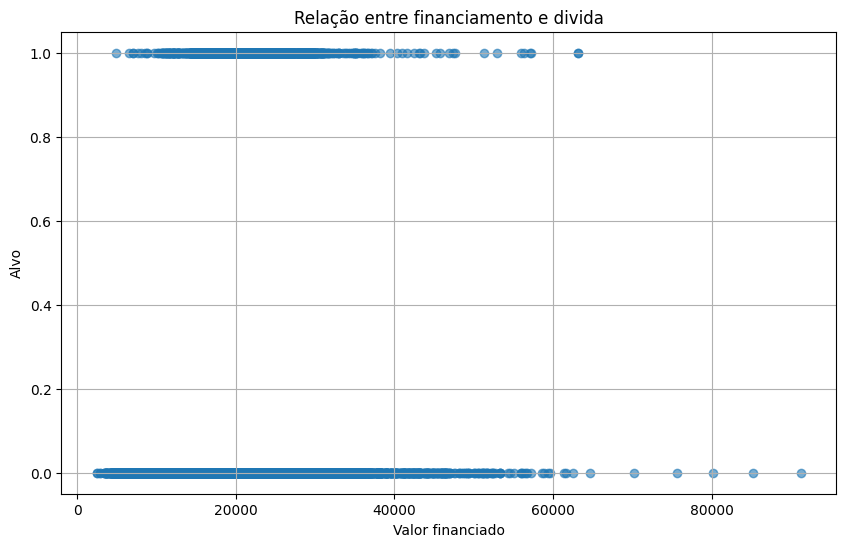

In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(base_antifraude['vlr_financiado'], base_antifraude['alvo'], alpha=0.6)
plt.xlabel('Valor financiado')
plt.ylabel('Alvo')
plt.title('Relação entre financiamento e divida')
plt.grid(True)
plt.show()

Percebemos aqui que quase não há fraudes para valores altos, porém esse gráfico não nos ajuda muito

C:\Users\osasi\AppData\Local\Temp\ipykernel_21528\1372934342.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxa_fraude_faixa = base_antifraude.groupby('faixa_valor')['alvo'].mean().reset_index()
C:\Users\osasi\AppData\Local\Temp\ipykernel_21528\1372934342.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taxa_fraude_faixa['count'] = base_antifraude.groupby('faixa_valor').size().values


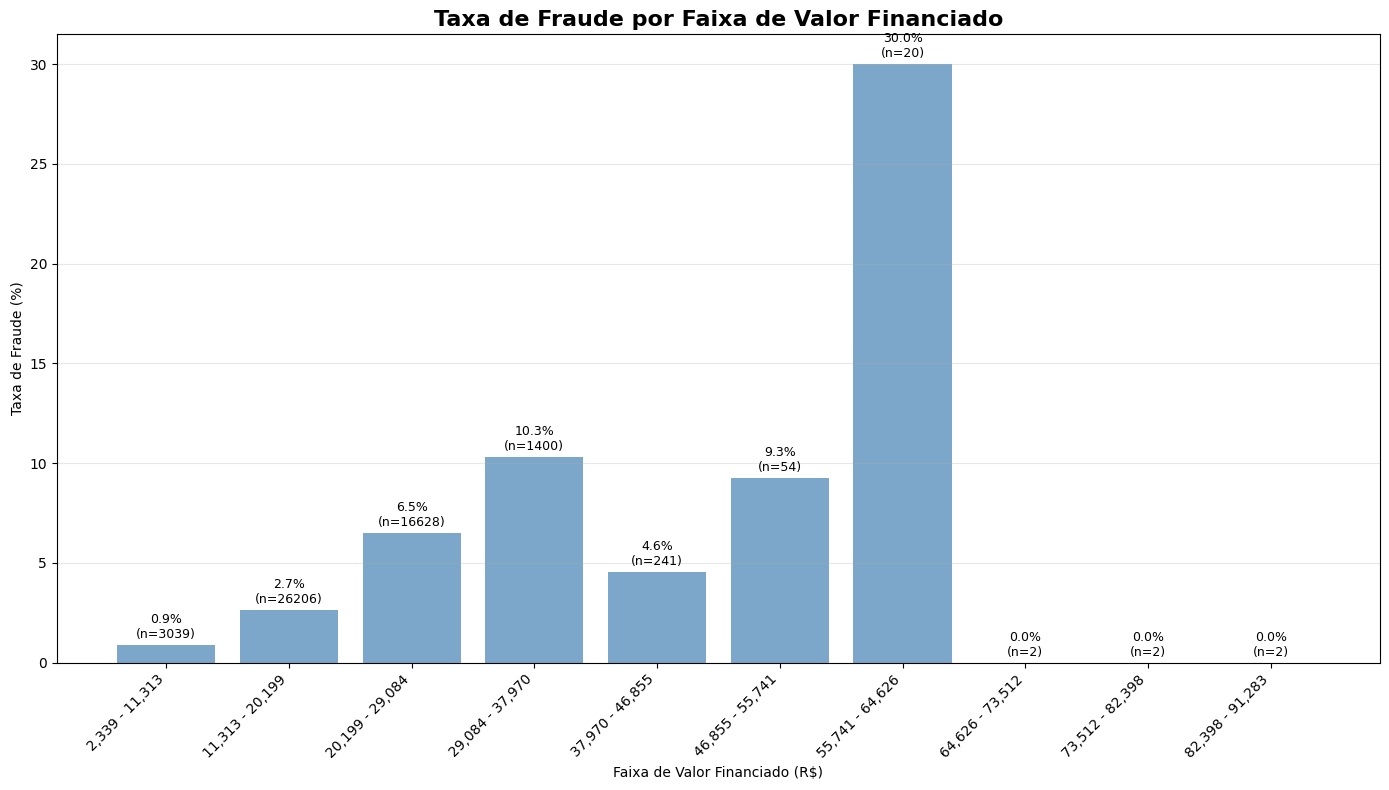

In [66]:
base_antifraude['faixa_valor'] = pd.cut(base_antifraude['vlr_financiado'], 
                                       bins=10, 
                                       include_lowest=True)

taxa_fraude_faixa = base_antifraude.groupby('faixa_valor')['alvo'].mean().reset_index()
taxa_fraude_faixa['count'] = base_antifraude.groupby('faixa_valor').size().values

plt.figure(figsize=(14, 8))
bars = plt.bar(range(len(taxa_fraude_faixa)), 
               taxa_fraude_faixa['alvo'] * 100, 
               alpha=0.7, 
               color='steelblue')

plt.title('Taxa de Fraude por Faixa de Valor Financiado', fontsize=16, fontweight='bold')
plt.xlabel('Faixa de Valor Financiado (R$)')
plt.ylabel('Taxa de Fraude (%)')
plt.xticks(range(len(taxa_fraude_faixa)), 
           [f'{int(interval.left):,} - {int(interval.right):,}' 
            for interval in taxa_fraude_faixa['faixa_valor']], 
           rotation=45, ha='right')

for i, (bar, taxa, count) in enumerate(zip(bars, taxa_fraude_faixa['alvo'], taxa_fraude_faixa['count'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{taxa*100:.1f}%\n(n={count})', 
             ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Esse gráfico é muito interessante, pois nele é visto que para faixas mais altas acima de 55k, a chance de fraude é muito maior(6/26 = 23%) que as demais, mais que o dobro da maior probabilidade anteriormente.

In [67]:
base_antifraude = base_antifraude.drop('faixa_valor', axis = 1)

Além do valor financiado também é importante analisar o mês de referência

In [68]:
print(base_antifraude['mes_ref'].unique())
print(base_antifraude['mes_ref'].isnull().sum())

[202307 202308 202309 202310 202311 202312]
0


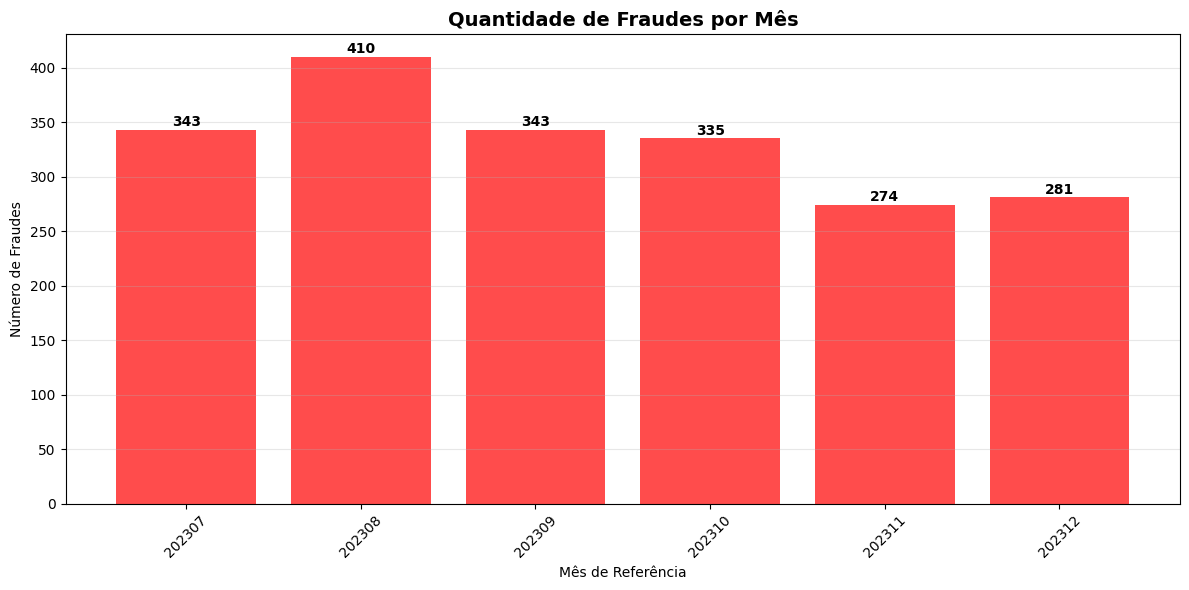

Total de fraudes: 1986


In [69]:
fraudes_por_mes = base_antifraude[base_antifraude['alvo'] == 1].groupby('mes_ref').size()

plt.figure(figsize=(12, 6))
bars = plt.bar(fraudes_por_mes.index.astype(str), fraudes_por_mes.values, 
               color='red', alpha=0.7)

plt.title('Quantidade de Fraudes por Mês', fontsize=14, fontweight='bold')
plt.xlabel('Mês de Referência')
plt.ylabel('Número de Fraudes')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, 
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total de fraudes: {fraudes_por_mes.sum()}")

É notório o aumento das fraudes em Agosto, faz sentido ser mais alto do que os meses do fim do ano, já que final de ano em geral os gastos são voltados para presentes e festas, consequentemente diminuindo as fraudes, porém não consigo achar um motivo claro para a diferença entre os meses de julho e setembro

In [70]:
print(len(base_antifraude['VAR1'].unique()))
print(len(base_antifraude['VAR197'].unique()))

14
8


Observei essas variáveis e percebi que por mais que o dataset possua muitas linhas, elas não tem uma grande variedade de seus dados, o que leva a crer que se tratam de valores fixos(uma possível categoria numérica), por isso não faz sentido fazer o tratamento de seus dados nulos por meio de média. Para features com esse comportamente de pouca diversidade nos dados irei substituir os dados pelos 3 números que mais se repetem na features para não deturpar a distribuição da feature

In [ ]:
numericas_categoricas = []

for col in numericas:
    if base_antifraude[col].isnull().sum() > 0:  

        if base_antifraude[col].nunique() < 30:

            top_3_valores = base_antifraude[col].value_counts().head(3).index.tolist() # Pega os 3 valores mais "contados"(de maior quantidade)   
            numericas_categoricas.append(col)

            mask_nulos = base_antifraude[col].isnull()
            valores_substituicao = np.random.choice(top_3_valores, size=mask_nulos.sum()) # Randomiza as escolhas do top 3 valores repetidos
            base_antifraude.loc[mask_nulos, col] = valores_substituicao

        else: # Esse else aborda por exemplo o valor financiado que não fez sentido aplicarmos esse filtro, já que o valor mais repetido poderia ser um valor fixo de financiamento que não condiz com a realidade geral do financiamentos
           
            media = base_antifraude[col].median()
            base_antifraude[col].fillna(media, inplace=True)

In [72]:
base_antifraude

,mes_ref,alvo,vlr_financiado,VAR1,VAR2,VAR3,VAR4,VAR6,VAR10,VAR11,...,VAR175_K,VAR185_ALTISSIMA,VAR185_BAIXISSIMA,VAR185_Desconhecido,VAR185_MEDIA,VAR199_Desconhecido,VAR199_NORDESTE,VAR199_NORTE,VAR199_SUDESTE,VAR199_SUL
0,202307,0.0,17820.60,0.166667,0.0,0.0,1.000000,0.0,0.30,0.418605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,202307,0.0,18513.56,0.166667,0.0,0.0,0.027211,0.0,0.04,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,202307,0.0,22943.80,0.000000,0.0,0.0,0.013605,0.0,0.00,0.069767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,202307,0.0,19177.58,0.083333,0.0,0.0,0.020408,0.0,0.02,0.116279,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,202307,0.0,16644.85,0.000000,0.0,0.0,0.000000,0.0,0.00,0.093023,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47727,202307,0.0,12732.20,0.166667,0.0,1.0,0.000000,0.0,0.12,0.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
47728,202308,0.0,7361.85,0.000000,1.0,1.0,0.000000,0.0,0.12,0.046512,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47729,202308,0.0,11127.31,0.083333,0.5,0.0,0.000000,0.0,0.12,0.046512,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
47730,202307,0.0,10800.15,0.166667,1.0,0.0,0.000000,0.0,0.12,0.023256,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [73]:
df_numericas = base_antifraude
# Calcular matriz de correlação de Pearson
correlacao_pearson = df_numericas.corr(method='pearson')

In [74]:
def analisar_correlacoes(df, target_col=None, threshold=0.5):

    corr_matrix = df.corr()
    
    print("=== ANÁLISE DE CORRELAÇÕES ===")
    
    if target_col and target_col in df.columns:
        print(f"\nCorrelações com a variável target '{target_col}':")
        correlacoes_target = corr_matrix[target_col].sort_values(ascending=False)
        for feature, corr in correlacoes_target.items():
            if feature != target_col:
                print(f"  {feature}: {corr:.3f}")
    
    # Correlações fortes entre features (multicolinearidade)
    print(f"\nCorrelações fortes (|r| > {threshold}) entre features:")
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                print(f"  {col1} x {col2}: {corr_matrix.iloc[i, j]:.3f}")

# Exemplo de uso
analisar_correlacoes(df_numericas, target_col='fraude', threshold=0.9)

=== ANÁLISE DE CORRELAÇÕES ===

Correlações fortes (|r| > 0.9) entre features:
  VAR1 x VAR154: 0.942
  VAR10 x VAR172: 0.909
  VAR42 x VAR46: 0.998
  VAR68 x VAR83: 0.932
  VAR111 x VAR191: 0.917
  VAR31_N x VAR104_S: 0.964
  VAR41_Desconhecido x VAR112_Desconhecido: 1.000
  VAR41_Desconhecido x VAR185_Desconhecido: 1.000
  VAR52_Desconhecido x VAR175_Desconhecido: 0.995
  VAR112_Desconhecido x VAR185_Desconhecido: 1.000


Certamente o fato deles terem correlações iguais a 1 mesmo sendo originalmente de features diferentes denota um padrão na forma como os dados foram coletados, que caso não tivesse acesso a uma informação não teria ao restante

In [75]:
base_antifraude = base_antifraude.drop('VAR185_Desconhecido', axis = 1)
base_antifraude = base_antifraude.drop('VAR41_Desconhecido', axis = 1)
base_antifraude = base_antifraude.drop('VAR1', axis = 1)
base_antifraude = base_antifraude.drop('VAR10', axis = 1)
base_antifraude = base_antifraude.drop('VAR191', axis = 1)

# Eliminando features com altissimas correlações, pois elas podem atrapalhar o modelo


A seguir serão feitas análises gráficas das correlações entre a feature e o alvo

TOP 20 CORRELAÇÕES POSITIVAS
 1. VAR124                   : +0.1330
 2. VAR3                     : +0.1276
 3. vlr_financiado           : +0.1165
 4. VAR78                    : +0.1061
 5. VAR119_Desconhecido      : +0.0982
 6. VAR101                   : +0.0772
 7. VAR33                    : +0.0745
 8. VAR69                    : +0.0660
 9. VAR154                   : +0.0659
10. VAR172                   : +0.0643
11. VAR1                     : +0.0635
12. VAR99                    : +0.0629
13. VAR36                    : +0.0623
14. VAR10                    : +0.0576
15. VAR199_NORDESTE          : +0.0569
16. VAR128                   : +0.0464
17. VAR86                    : +0.0424
18. VAR111                   : +0.0403
19. VAR191                   : +0.0383
20. VAR46                    : +0.0377


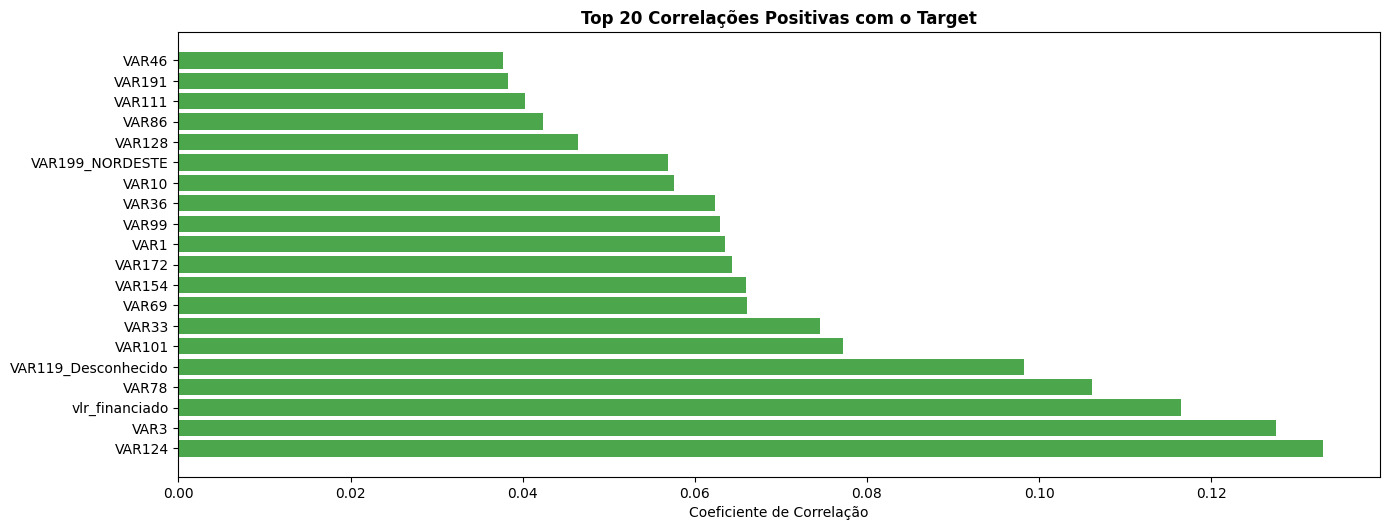

In [76]:

correlacoes_com_target = df_numericas.corr()['alvo'].drop('alvo')

top_20_positivas = correlacoes_com_target.sort_values(ascending=False).head(20)
top_20_negativas = correlacoes_com_target.sort_values(ascending=True).head(20)

print("TOP 20 CORRELAÇÕES POSITIVAS")
for i, (feature, corr) in enumerate(top_20_positivas.items(), 1):
    print(f"{i:2d}. {feature:25s}: {corr:+.4f}")

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.barh(range(len(top_20_positivas)), top_20_positivas.values, color='green', alpha=0.7)
plt.yticks(range(len(top_20_positivas)), top_20_positivas.index)
plt.title('Top 20 Correlações Positivas com o Target', fontweight='bold')
plt.xlabel('Coeficiente de Correlação')

plt.tight_layout()
plt.show()


Note que a categorização do do valor financiado não agregou muito a base de dados, por isso não faz sentido tê-la

In [77]:
base_antifraude['VAR124']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
47727    1.0
47728    1.0
47729    1.0
47730    1.0
47731    1.0
Name: VAR124, Length: 47732, dtype: float64


TOP 20 CORRELAÇÕES NEGATIVAS
1.VAR199_Desconhecido      : -0.0475
2.VAR184                   : -0.0397
3.VAR81                    : -0.0365
4.VAR193                   : -0.0319
5.VAR67                    : -0.0296
6.VAR119_Y                 : -0.0283
7.VAR93                    : -0.0278
8.VAR186                   : -0.0267
9.VAR66                    : -0.0249
10.VAR135                   : -0.0243
11.VAR119_D                 : -0.0212
12.VAR132                   : -0.0212
13.VAR199_NORTE             : -0.0212
14.VAR119_E                 : -0.0211
15.VAR175_Desconhecido      : -0.0200
16.VAR119_J                 : -0.0198
17.VAR52_Desconhecido       : -0.0196
18.VAR119_N                 : -0.0194
19.VAR119_M                 : -0.0191
20.VAR28                    : -0.0190


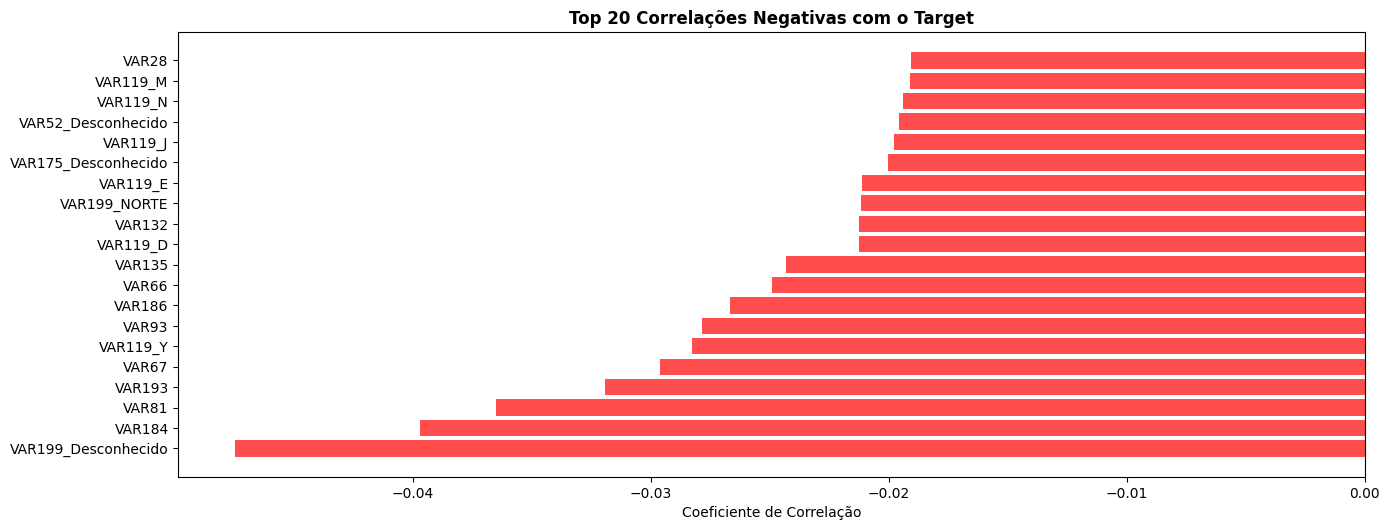

In [78]:
top_20_negativas = correlacoes_com_target.sort_values(ascending=True).head(20)

print("\nTOP 20 CORRELAÇÕES NEGATIVAS")

for i, (feature, corr) in enumerate(top_20_negativas.items(), 1):
    print(f"{i:d}.{feature:25s}: {corr:+.4f}")

plt.figure(figsize=(14, 10))

# Negativas
plt.subplot(2, 1, 2)
plt.barh(range(len(top_20_negativas)), top_20_negativas.values, color='red', alpha=0.7)
plt.yticks(range(len(top_20_negativas)), top_20_negativas.index)
plt.title('Top 20 Correlações Negativas com o Target', fontweight='bold')
plt.xlabel('Coeficiente de Correlação')

plt.tight_layout()
plt.show()

In [79]:
base_antifraude['VAR184']

0        0.001001
1        1.000000
2        0.005005
3        1.000000
4        1.000000
           ...   
47727    0.542543
47728    1.000000
47729    1.000000
47730    1.000000
47731    0.549550
Name: VAR184, Length: 47732, dtype: float64

In [80]:
base_antifraude['VAR81']

0        0.408614
1        0.448414
2        0.448414
3        0.448414
4        0.393659
           ...   
47727    0.813007
47728    0.576257
47729    0.452997
47730    0.448414
47731    0.737870
Name: VAR81, Length: 47732, dtype: float64

Posteriormente irei fazer testar a mudança no preenchimento das nossas features "numéricas categóricas" que são aquelas que possuem pouca diversidade em sua colunas

# Treinamento do modelo

Para o treinamento de um modelo é necessário antes ser observado se há algum tipo de desbalanceamento no dataset

In [81]:
n = 0
for i in range(len(base_antifraude['alvo'])):
    if base_antifraude['alvo'][i] == 1:
        n += 1
prop = n/len(base_antifraude['alvo'])

print(f"Proporção da classe target em relação ao total : {prop}")

Proporção da classe target em relação ao total : 0.04160730746668902


Para esse tipo de balanceamento imagino duas abordagens que são: Treinar usando o kfold estratificado que garante que sempre vai haver a classe desbalanceada nos folds de treinamento e/ou usando métodos de oversampling para aumentar a classe minoritária

Para explorar melhor as possibilidades irei usar mais de um modelo para os treinos. Os modelos escolhidos foram: XGBoost, LightGBM, CatBoost, Random Forest e Regressão Logística

In [83]:
base_antifraude

,mes_ref,alvo,vlr_financiado,VAR2,VAR3,VAR4,VAR6,VAR11,VAR14,VAR18,...,VAR175_J,VAR175_K,VAR185_ALTISSIMA,VAR185_BAIXISSIMA,VAR185_MEDIA,VAR199_Desconhecido,VAR199_NORDESTE,VAR199_NORTE,VAR199_SUDESTE,VAR199_SUL
0,202307,0.0,17820.60,0.0,0.0,1.000000,0.0,0.418605,0.0,0.030092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,202307,0.0,18513.56,0.0,0.0,0.027211,0.0,0.000000,0.0,0.071105,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,202307,0.0,22943.80,0.0,0.0,0.013605,0.0,0.069767,0.0,0.080593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,202307,0.0,19177.58,0.0,0.0,0.020408,0.0,0.116279,0.0,0.044997,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,202307,0.0,16644.85,0.0,0.0,0.000000,0.0,0.093023,0.0,0.359038,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47727,202307,0.0,12732.20,0.0,1.0,0.000000,0.0,0.000000,0.0,0.071105,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
47728,202308,0.0,7361.85,1.0,1.0,0.000000,0.0,0.046512,0.0,0.247702,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
47729,202308,0.0,11127.31,0.5,0.0,0.000000,0.0,0.046512,0.0,0.000205,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
47730,202307,0.0,10800.15,1.0,0.0,0.000000,0.0,0.023256,0.0,0.060199,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# X_80, X_20, y_80, y_20 = train_test_split(
#     base_antifraude.drop('alvo', axis = 1), base_antifraude["alvo"], test_size=0.2, stratify=base_antifraude["alvo"], random_state=42
# )

x_80 = base_antifraude.drop(['alvo'], axis = 1)
y_80 = base_antifraude['alvo']

## Tunando modelos com o optuna sem oversampling

Resolvi usar o optuna pois nele consigo mais facilmente focar no tunning de métricas que eu julgar mais importantes.

Então para isso selecionei 3 modelos e testa-los o XGBoost, LightGBM e Random forest(inicialmente tinha sido o catboost, mas devido a demora do treinamento optei pelo troca).

### Tunando o XGBoost 

In [93]:
import xgboost as xgb

In [94]:
def objective_xgb(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",  
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "n_estimators": 2000
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    precisions = []

    for train_idx, val_idx in kf.split(x_80, y_80):
        X_train, X_val = x_80.iloc[train_idx], x_80.iloc[val_idx]
        y_train, y_val = y_80.iloc[train_idx], y_80.iloc[val_idx]

        model = xgb.XGBClassifier(**params, tree_method="hist", n_jobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        preds = model.predict(X_val)
        precisions.append(precision_score(y_val, preds, zero_division=0))

    return np.mean(precisions)

In [ ]:
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)
print("Melhores parâmetros XGB:", study_xgb.best_params)
print("Melhor Precisão XGB:", study_xgb.best_value)

In [ ]:
def objective_xgb_auprc(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "n_estimators": 2000
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auprcs = []

    for train_idx, val_idx in kf.split(x_80, y_80):
        X_train, X_val = x_80.iloc[train_idx], x_80.iloc[val_idx]
        y_train, y_val = y_80.iloc[train_idx], y_80.iloc[val_idx]

        model = xgb.XGBClassifier(**params, tree_method="hist", n_jobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        preds_proba = model.predict_proba(X_val)[:, 1]
        auprcs.append(average_precision_score(y_val, preds_proba))

    return np.mean(auprcs)


In [ ]:
study_auprc = optuna.create_study(direction="maximize")
study_auprc.optimize(objective_xgb_auprc, n_trials=25)
print("Melhores parâmetros XGB:", study_auprc.best_params)
print("Melhor AUPRCS XGB:", study_auprc.best_value)

### Tunando o LightGBM

In [ ]:
def objective_lgb(trial):
    params = {
        "objective": "binary",
        "metric": "None",  
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "class_weight": "balanced",
        "n_estimators": 2000
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    precisions = []

    for train_idx, val_idx in kf.split(x_80, y_80):
        X_train, X_val = x_80.iloc[train_idx], x_80.iloc[val_idx]
        y_train, y_val = y_80.iloc[train_idx], y_80.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],callbacks=[lgb.log_evaluation(period=0)  ])  

        preds = model.predict(X_val)
        precisions.append(precision_score(y_val, preds, zero_division=0))

    return np.mean(precisions)

In [ ]:
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=30)
print("Melhores parâmetros LightGBM:", study_lgb.best_params)
print("Melhor Precisão LGBM:", study_lgb.best_value)

In [ ]:
def objective_lgbm_f1(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in kf.split(x_80, y_80):
        X_train, X_val = x_80.iloc[train_idx], x_80.iloc[val_idx]
        y_train, y_val = y_80.iloc[train_idx], y_80.iloc[val_idx]

        model = lgb.LGBMClassifier(**params, n_estimators=1000, n_jobs=-1)
        model.fit(X_train, y_train, 
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50)])

        preds = model.predict(X_val)
        f1_scores.append(f1_score(y_val, preds, zero_division=0))

    return np.mean(f1_scores)

In [ ]:
study_lgb_f1 = optuna.create_study(direction="maximize")
study_lgb_f1.optimize(objective_lgbm_f1, n_trials=30)
print("Melhores parâmetros LightGBM:", study_lgb_f1.best_params)
print("Melhor F1-SCORE LGBM:", study_lgb_f1.best_value)

### Random Forest

In [ ]:
def objective_rf_auprc(trial):
    """
    Random Forest otimizado para AUPRC (Average Precision)
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 8, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 15),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": "balanced",
        "bootstrap": True,
        "random_state": 42,
        "n_jobs": -1
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auprc_scores = []

    for train_idx, val_idx in kf.split(x_80, y_80):
        X_train, X_val = x_80.iloc[train_idx], x_80.iloc[val_idx]
        y_train, y_val = y_80.iloc[train_idx], y_80.iloc[val_idx]

        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)

        # Probabilidades da classe positiva
        probs = model.predict_proba(X_val)[:, 1]

        # Calcula AUPRC
        auprc = average_precision_score(y_val, probs)
        auprc_scores.append(auprc)

    return np.mean(auprc_scores)


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_rf_auprc, n_trials=30, show_progress_bar=True)

# Ver resultados
print("Melhor F1-score:", study.best_value)
print("Melhores parâmetros:", study.best_params)

## Tunando modelos usando optuna e com oversampling

Como o target está extremamente desbalanceado devemos ponderar que, não podemos somente repetir a classe minoritaria até ela deixa de ser minoritária, pois isso geraria um overfitting o mais correto seria a criação de amostras sintéticas muito próximas das amostras que já temos. Pelo curto tempo do projeto não irei explorar muito esses métodos. A técnica que irei implementar será o Borderline-SMOTE.

### XGBoost

In [ ]:
def objective_xgb_smote(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",  
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "n_estimators": 2000
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    precisions = []

    for train_idx, val_idx in kf.split(x_80, y_80):
        X_train, X_val = x_80.iloc[train_idx], x_80.iloc[val_idx]
        y_train, y_val = y_80.iloc[train_idx], y_80.iloc[val_idx]

        smote = BorderlineSMOTE(random_state=42, kind="borderline-1")  
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        model = xgb.XGBClassifier(**params, tree_method="hist", n_jobs=-1)
        model.fit(X_train_res, y_train_res, eval_set=[(X_val, y_val)], verbose=False)

        preds = model.predict(X_val)
        precisions.append(precision_score(y_val, preds, zero_division=0))

    return np.mean(precisions)


In [ ]:
study_xgb_smote = optuna.create_study(direction="maximize")
study_xgb_smote.optimize(objective_xgb_smote, n_trials=30)
print("Melhores parâmetros XGB:", study_xgb_smote.best_params)
print("Melhor precisão XGB:", study_xgb_smote.best_value)

### LightGBM

In [ ]:
def objective_lgb_smote(trial):
    params = {
        "objective": "binary",
        "metric": "None",  # precision calculado manualmente
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "class_weight": "balanced",
        "n_estimators": 2000
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    precisions = []

    for train_idx, val_idx in kf.split(x_80, y_80):
        X_train, X_val = x_80.iloc[train_idx], x_80.iloc[val_idx]
        y_train, y_val = y_80.iloc[train_idx], y_80.iloc[val_idx]

        # ---- Borderline-SMOTE aplicado só no treino ----
        smote = BorderlineSMOTE(random_state=42, kind="borderline-1")
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        # ---- Treinando o modelo ----
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train_res, y_train_res,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.log_evaluation(period=0)]
        )

        preds = model.predict(X_val)
        precisions.append(precision_score(y_val, preds, zero_division=0))

    return np.mean(precisions)


In [ ]:
study_lgb_smote = optuna.create_study(direction="maximize")
study_lgb_smote.optimize(objective_lgb_smote, n_trials=30)
print("Melhores parâmetros LightGBM:", study_lgb_smote.best_params)
print("Melhor Precisão LGBM:", study_lgb_smote.best_value)

# Validação do modelo

A validação do modelo separei em duas partes para ficar mais didático, a primeira parte consiste em só testar no 20% da base restante e apresentar as métricas e a segunda usei um método chamado precision@k em que ele pega o array com os resultados da previsão e seleciona os top k% desse array

In [ ]:
def precision_at_top_percent(y_true, y_scores, percent=0.01):
    k = max(1, int(len(y_true) * percent))
    top_k_idx = np.argsort(y_scores)[-k:]
    y_pred = np.zeros_like(y_true)
    y_pred[top_k_idx] = 1
    return precision_score(y_true, y_pred, zero_division=0)

def recall_at_top_percent(y_true, y_scores, percent=0.01):
    k = max(1, int(len(y_true) * percent))
    top_k_idx = np.argsort(y_scores)[-k:]
    y_pred = np.zeros_like(y_true)
    y_pred[top_k_idx] = 1
    return recall_score(y_true, y_pred, zero_division=0)

## Método de validação 1

In [108]:
X_80, X_20, y_80, y_20 = train_test_split(
  base_antifraude.drop('alvo', axis = 1), base_antifraude["alvo"], test_size=0.2, stratify=base_antifraude["alvo"], random_state=42)
best_params = {
    'learning_rate':  0.0013385732748072018,
    'max_depth': 4,
    'subsample': 0.8125493255720256,
    'colsample_bytree': 0.6423114656619616,
    'reg_lambda': 0.44962462873018477,  
    'reg_alpha': 0.07289583653301906,
    'n_estimators': 2000,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False
}


modelo_final_1 = xgb.XGBClassifier(**best_params)
modelo_final_1.fit(X_80, y_80)

y_pred = modelo_final_1.predict(X_20)
y_proba = modelo_final_1.predict_proba(X_20)[:,1]


precision = precision_score(y_20, y_pred)
recall = recall_score(y_20, y_pred)
pr_auc = average_precision_score(y_20, y_proba)

print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

c:\Users\osasi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:46:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Precisão: 0.7963
Recall: 0.1083
PR AUC: 0.2932


In [109]:
from sklearn.metrics import precision_score, recall_score, average_precision_score
import numpy as np

y_pred = modelo_final_1.predict(x_20)
y_proba = modelo_final_1.predict_proba(x_20)[:,1]

precision = precision_score(y_20, y_pred)
recall = recall_score(y_20, y_pred)
pr_auc = average_precision_score(y_20, y_proba)

print(f"Precisão (threshold=0.5): {precision:.4f}")
print(f"Recall (threshold=0.5): {recall:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

for p in [0.01, 0.015, 0.02, 0.025, 0.04]:
    prec_k = precision_at_top_percent(y_20.values, y_proba, percent=p)
    rec_k = recall_at_top_percent(y_20.values, y_proba, percent=p)
    print(f"Top {(p*100)}% -> Precision: {prec_k:.4f}, Recall: {rec_k:.4f}")


Precisão (threshold=0.5): 0.7963
Recall (threshold=0.5): 0.1083
PR AUC: 0.2932
Top 1.0% -> Precision: 0.6632, Recall: 0.1587
Top 1.5% -> Precision: 0.5455, Recall: 0.1965
Top 2.0% -> Precision: 0.4895, Recall: 0.2343
Top 2.5% -> Precision: 0.4202, Recall: 0.2519
Top 4.0% -> Precision: 0.3202, Recall: 0.3073


## Método de validação 2

In [105]:
base_teste = base_antifraude.drop('alvo', axis = 1)
y_teste = base_antifraude['alvo']

best_params = {
    'learning_rate':  0.005407577715699033,
    'max_depth': 4,
    'subsample': 0.8870678279486477,
    'colsample_bytree': 0.5313149328104163,
    'reg_lambda': 7.824025934775027,  
    'reg_alpha':0.007733658787870559,
    'n_estimators': 2000,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False
}


modelo_final_2 = xgb.XGBClassifier(**best_params)
modelo_final_2.fit(base_teste, y_teste)

y_pred = modelo_final_2.predict(base_teste)
y_proba = modelo_final_2.predict_proba(base_teste)[:,1]


precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
pr_auc = average_precision_score(y_teste, y_proba)

print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

c:\Users\osasi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:44:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Precisão: 0.8679
Recall: 0.2150
PR AUC: 0.4580


In [106]:
y_pred = modelo_final_2.predict(base_teste)
y_proba = modelo_final_2.predict_proba(base_teste)[:,1]

precision = precision_score(y_teste, y_pred)
recall = recall_score(y_teste, y_pred)
pr_auc = average_precision_score(y_teste, y_proba)

print(f"Precisão (threshold=0.5): {precision:.4f}")
print(f"Recall (threshold=0.5): {recall:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

for p in [0.01, 0.015, 0.02, 0.025, 0.04]:
    prec_k = precision_at_top_percent(y_teste.values, y_proba, percent=p)
    rec_k = recall_at_top_percent(y_teste.values, y_proba, percent=p)
    print(f"Top {(p*100)}% -> Precision: {prec_k:.4f}, Recall: {rec_k:.4f}")


Precisão (threshold=0.5): 0.8679
Recall (threshold=0.5): 0.2150
PR AUC: 0.4580
Top 1.0% -> Precision: 0.8742, Recall: 0.2100
Top 1.5% -> Precision: 0.7678, Recall: 0.2764
Top 2.0% -> Precision: 0.6740, Recall: 0.3238
Top 2.5% -> Precision: 0.6018, Recall: 0.3615
Top 4.0% -> Precision: 0.4500, Recall: 0.4325


# Considerações sobre o projeto e o modelo

 Foram feitos muitos testes mudando os seguintes pilares do projeto: eliminação ou não das colunas com 80% de dados nulos, testando em modelos diferentes: XGBoost, LightGBM, CatBoost e Random forest, com e sem oversampling. E variando as métricas de avaliação (Precision, recall, PR-AUC). 

Inicialmente a idéia que tive foi treinar com optuna voltado para a precisão e acoplar com o precision@k, pensei erroneamente que nos tops do array de resultados estaria de fato os targets, porém isso não ocorreu e abaixou muito a precisão de modelo e isso me demandou muito tempo. Quando percebi que não deu certo mudei a métrica de avaliação para o PR-AUC que me daria esse trade-off melhor entre precisão e recall.

Fiz outro teste muito importante também que não citei acima, além de testar usando 80% da base para kfold e o outros 20% para validação, treinei com K-FOLD estratificado a base toda e obtive resultados MUITO melhores, suspeitei então que os alvos não eram tão homogeneos, pesquisando vi era importante avaliar os meses de maneira mais aprofundada no modelo, infelizmente isso não pôde ser feito, mas fica como aprendizado. Talvez fazer um modelo pra cada mês presente no dataset seja uma boa opção.

Continuando com a idéia acima fiz dois métodos de avaliação o primeiro usando o train_spli + kfold e outro utilizando somente o kfold e validação na base posteriormente. Já que o treinamento é feito em folds acredito que não seja necessário a separação entre train_split

A escolha do modelo portanto foi do modelo de validação 2 usando k = 0.015 que apresentou a maior precisão considerando o trade-off com o recall

Utilizei ChatGPT e DeepSeek para plotar os gráficos e refinar o tunning do optuna